In [1]:
from surprise import accuracy
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF
from surprise.model_selection.validation import cross_validate
from surprise.model_selection.search import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
""

''

In [3]:
raw_db = pd.read_csv('data/ml-latest-small/ratings.csv')
raw_db

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
raw_db.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


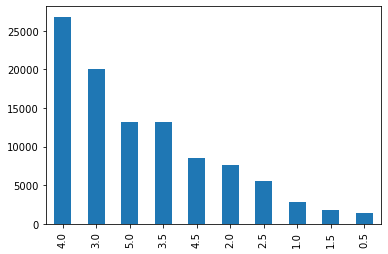

In [5]:
raw_db.rating.value_counts().plot(kind='bar')
plt.show()

In [6]:
raw_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
raw_db.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [8]:
raw_db = raw_db[['userId', 'movieId', 'rating']]
raw_db = raw_db.iloc[:, :]
raw_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [9]:
reader = Reader()
data = Dataset.load_from_df(raw_db[['userId', 'movieId', 'rating']], reader)

In [10]:
trainset, testset = train_test_split(data, test_size=0.25)

In [13]:
factors = 15
epochs = 50
biased = True
reg_pu = 0.06
reg_qi = 0.06
reg_bu = 0.02
reg_bi = 0.02
lr_bu = 0.02
lr_bi = 0.005
init_low = 0

nmf = NMF(n_factors = factors, n_epochs = epochs, lr_bu = .1)
nmf.fit(trainset)

In [24]:
nmf_predictions = nmf.test(testset)

In [45]:
results.loc['NMF'] = accuracy.rmse(nmf_predictions)

RMSE: 0.9286


In [28]:
cross_validate(nmf, data)

{'test_rmse': array([0.91923262, 0.92285445, 0.92148994, 0.92147518, 0.92564081]),
 'test_mae': array([0.70476897, 0.70800128, 0.7092729 , 0.70670785, 0.70808636]),
 'fit_time': (4.735999822616577,
  4.639024496078491,
  4.7799999713897705,
  4.983999729156494,
  4.684999227523804),
 'test_time': (0.10402464866638184,
  0.1790008544921875,
  0.0940253734588623,
  0.10399985313415527,
  0.1100006103515625)}

In [27]:
factors = 10
epochs = 20
init_mean = 0
init_std_dev = .1
reg_all = 0.1
lr_all = .005
svd = SVD(n_factors = 2, n_epochs = 32, lr_all = .01, reg_all = 0)
svd.fit(trainset)

In [16]:
{'n_factors': 2, 'n_epochs': 32, 'lr_all': 0.01, 'reg_all': 0}

{'n_factors': 2, 'n_epochs': 32, 'lr_all': 0.01, 'reg_all': 0}

In [18]:
svd_predictions = svd.test(testset)

In [46]:
results.loc['SVD'] = accuracy.rmse(svd_predictions)

RMSE: 0.8842


In [16]:
factors = 20
epochs = 10
init_mean = 0
init_std_dev = .1
reg_all = .02
lr_all = .005

svdpp = SVDpp(n_factors = factors, n_epochs = epochs, verbose = True)
svdpp.fit(trainset)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9


In [51]:
svdpp_predictions = svdpp.test(testset)

In [24]:
est = svdpp.predict(1, 5).est

In [25]:
est

3.7291328304823717

In [11]:
with open('src/flask_example/svdpp.sav','rb') as f:
        model = pickle.load(f)

In [12]:
model.predict(2, 303)

Prediction(uid=2, iid=303, r_ui=None, est=3.363551287472872, details={'was_impossible': False})

In [17]:
all_recs = []
user = 2
movie_df = pd.read_csv('data/ml-latest-small/movies.csv')
for movie in range(len(model.qi)):
    all_recs.append(model.predict(user,movie).est)
indices = np.argsort(all_recs)[:-10-1:-1]
full_recs = []
for idx,movie in enumerate(indices):
    rec = []
    rec.append(movie) 
    rec.append(movie_df['title'].iloc[movie])
    full_recs.append(rec)
for i in range(len(indices)):
    full_recs[i][0] = int(full_recs[i][0])

In [25]:
len(all_recs)

8785

In [18]:
indices

array([ 750, 1204,  318, 1193,   50,  912, 1136, 1221,  904, 1276])

In [20]:
np.argsort(all_recs)

array([2701, 1499, 3593, ...,  318, 1204,  750])

In [24]:
model.predict(2,318)

Prediction(uid=2, iid=318, r_ui=None, est=4.458802803422832, details={'was_impossible': False})

In [ ]:
750, 1204, 318, 1193, 50, 912, 1139, 1221, 904, 1276

In [ ]:
results.loc['SVD++'] = accuracy.rmse(svdpp_predictions)

In [62]:
with open('svdpp.sav', 'wb') as file:
    pickle.dump(svdpp, file)

In [90]:
def compare_factors(factors = [20], epochs = [20]):
    """
    Takes in dataset, runs it through svd, svdpp, nmf models with various parameter
    saves accuracty measure, returns record df and plot
    """
 

    if len(factors) > 1:
        accuracy_df = pd.DataFrame(columns=['model','factors','rmse'])
        for i in factors:
            svd = SVD(n_factors = i)
            nmf = NMF(n_factors = i)
            # svdpp = SVDpp(n_factors= i)

            svd.fit(trainset)
            svd_predictions = svd.test(testset)
            svd_acc = accuracy.rmse(svd_predictions)
            svd_trial = ['svd', i, svd_acc]

            nmf.fit(trainset)
            nmf_predictions = nmf.test(testset)
            nmf_acc = accuracy.rmse(nmf_predictions)
            nmf_trial = ['nmf', i, nmf_acc]
            

            # svdpp.fit(trainset)
            # svdpp_predictions = svdpp.test(testset)
            # svdpp_acc = accuracy.rmse(svdpp_predictions)
            # svdpp_trial = ['svdpp', i, svdpp_acc]

            accuracy_df.loc[len(accuracy_df.index)] = svd_trial
            accuracy_df.loc[len(accuracy_df.index)] = nmf_trial
            # accuracy_df.loc[len(accuracy_df.index)] = svd_trial

    elif len(epochs) > 1:
        accuracy_df = pd.DataFrame(columns=['model','epochs','rmse'])
        for i in factors:
            svd = SVD(n_factors = i)
            nmf = NMF(n_factors = i)
            # svdpp = SVDpp(n_factors= i)

            svd.fit(trainset)
            svd_predictions = svd.test(testset)
            svd_acc = accuracy.rmse(svd_predictions)
            svd_trial = ['svd', i, svd_acc]

            nmf.fit(trainset)
            nmf_predictions = nmf.test(testset)
            nmf_acc = accuracy.rmse(nmf_predictions)
            nmf_trial = ['nmf', i, nmf_acc]
            

            # svdpp.fit(trainset)
            # svdpp_predictions = svdpp.test(testset)
            # svdpp_acc = accuracy.rmse(svdpp_predictions)
            # svdpp_trial = ['svdpp', i, svdpp_acc]

            accuracy_df.loc[len(accuracy_df.index)] = svd_trial
            accuracy_df.loc[len(accuracy_df.index)] = nmf_trial
            # accuracy_df.loc[len(accuracy_df.index)] = svd_trial
    
    return accuracy_df
            



In [ ]:
#GridSearchCV needed a differently formatted data set than the others
data = Dataset.load_builtin('ml-100k')

In [98]:
param_grid = {'n_factors' : [10, 20],'n_epochs': [10, 20, 30], 'lr_all': [.01, .1],
              'verbose': [True]}

In [128]:
svd_grid = GridSearchCV(SVD, param_grid, measures = ['rmse'], n_jobs=-1)

In [129]:
svd_grid.fit(data)

In [106]:
data = Dataset.load_builtin('ml-100k')

In [130]:
print(grid.best_score['rmse'])
print(grid.best_params['rmse'])

0.9324506719658082
{'n_factors': 2, 'n_epochs': 32, 'lr_all': 0.01, 'reg_all': 0}


In [124]:
{'n_factors': 2, 'n_epochs': 32, 'lr_all': 0.01, 'reg_all': 0}

{'split0_test_rmse': array([0.98969861, 0.99668084, 0.96891679, 0.97784877, 0.97253936,
        0.98098199, 0.96013687, 0.97012578]),
 'split1_test_rmse': array([0.99720867, 1.00341338, 0.97559087, 0.98477868, 0.97932922,
        0.98780098, 0.96655115, 0.97682749]),
 'split2_test_rmse': array([0.98531431, 0.99214861, 0.96525509, 0.97435999, 0.96864283,
        0.97750295, 0.9572946 , 0.96714045]),
 'split3_test_rmse': array([0.99130236, 0.99780529, 0.96993352, 0.97893612, 0.9733225 ,
        0.98225155, 0.96092198, 0.97086098]),
 'split4_test_rmse': array([0.99153349, 0.99852276, 0.97023264, 0.9801043 , 0.97376616,
        0.98297615, 0.96119925, 0.97207569]),
 'mean_test_rmse': array([0.99101149, 0.99771418, 0.96998578, 0.97920557, 0.97352001,
        0.98230272, 0.96122077, 0.97140608]),
 'std_test_rmse': array([0.00381952, 0.00361072, 0.00331671, 0.00338409, 0.00342331,
        0.00333074, 0.00300308, 0.00316139]),
 'rank_test_rmse': array([7, 8, 2, 5, 4, 6, 1, 3], dtype=int64),
 '

In [142]:
grid2 = GridSearchCV(NMF, grid2_params, measures = ['rmse'], n_jobs=-1)

In [145]:
grid2_params = {'n_factors' : [20,30, 40],
'n_epochs' : [50,100],
'reg_pu' : [0.1],
'reg_qi' : [0.1],
'lr_bu' : [0.2]}

In [146]:
grid2.fit(data)

KeyboardInterrupt: 

In [144]:
print(grid2.best_score['rmse'])
print(grid2.best_params['rmse'])

0.948231443421505
{'n_factors': 20, 'n_epochs': 50, 'reg_pu': 0.1, 'reg_qi': 0.1, 'lr_bu': 0.2}


In [99]:
grid3 = GridSearchCV(SVDpp, param_grid, measures = ['rmse'], n_jobs=-1)

In [100]:
grid3.fit(data)

In [42]:
results = pd.DataFrame(columns=['RMSE'])

In [76]:
results

,RMSE
Mean of Means,1.13
NMF,0.92862
SVD,0.884207
SVD++,0.869291


In [54]:
results.loc['Mean of Means'] = 1.13

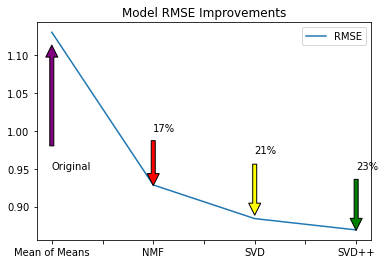

In [95]:
results.plot.line()
plt.annotate(text = 'Original', xy=(0,1.13),xytext =(0, .95),arrowprops = dict(facecolor ='purple', 
                                  shrink = 0.1))
plt.annotate(text = '17%', xy=(1,.92),xytext =(1, 1),arrowprops = dict(facecolor ='red', 
                                  shrink = 0.1))
plt.annotate(text = '21%', xy=(2,.88),xytext =(2, .97),arrowprops = dict(facecolor ='yellow', 
                                  shrink = 0.1))
plt.annotate(text = '23%', xy=(3,.86),xytext =(3, .95),arrowprops = dict(facecolor ='green', 
                                  shrink = 0.1))
plt.title("Model RMSE Improvements")
plt.savefig('images/model_improvements.jpg')

0.23071592920353978